In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
import math
import re
import requests
import random
import itertools
from numpy import mean, std

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

In [4]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [5]:
df_train = pd.read_csv(r'C:\Users\100_rabh\1. protium\Train_v1.2.csv',sep=',',encoding='utf-8',parse_dates=True)
df_test = pd.read_csv(r'C:\Users\100_rabh\1. protium\Test_v1.2.csv',sep=',',encoding='utf-8',parse_dates=True)

In [6]:
print("Shape of train:", df_train.shape)
print("Shape of test:", df_test.shape)

Shape of train: (97480, 34)
Shape of test: (24370, 34)


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97480 entries, 0 to 97479
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Patron_Salary                               97480 non-null  float64
 1   Automobile_Possession                       97480 non-null  int64  
 2   Two-Wheeler_Ownership                       97480 non-null  int64  
 3   Ongoing_Borrowing                           97480 non-null  int64  
 4   Residence_Proprietorship                    97480 non-null  int64  
 5   Offspring_Number                            97480 non-null  int64  
 6   Loan_Capital                                97480 non-null  float64
 7   Borrowing_Periodic_Payment                  97480 non-null  float64
 8   Customer_Revenue_Category                   97480 non-null  object 
 9   Patron_Academic_Qualification               97480 non-null  object 
 10  Customer_C

In [8]:
for i in df_train.columns:
    if df_train[i].dtypes == 'object':
        df_train[i] = df_train[i].str.upper()
        df_train[i] = df_train[i].str.strip()
        
        df_test[i] = df_test[i].str.upper()
        df_test[i] = df_test[i].str.strip()

In [9]:
# converting float to integer if column have 2 unique value
for i in df_train.columns:
    if df_train[i].dtypes == 'float':
        if df_train[i].nunique() <= 2:
            df_train[i] = df_train[i].astype(int)

In [10]:
# converting float to integer if column have 2 unique value
for i in df_test.columns:
    if df_test[i].dtypes == 'float':
        if df_test[i].nunique() <= 2:
            df_test[i] = df_test[i].astype(int)

### IV

In [11]:
def iv_woe(data, target, bins, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [12]:
iv, woe = iv_woe(data = df_train, target = 'Default', bins = 4, show_woe = True)

Information value of Patron_Salary is 0.010128
        Variable               Cutoff      N  Events  % of Events  Non-Events  \
0  Patron_Salary  (6749.999, 11250.0]  30980    2570     0.326349       28410   
1  Patron_Salary   (11250.0, 14400.0]  18366    1596     0.202667       16770   
2  Patron_Salary   (14400.0, 20250.0]  26138    2223     0.282286       23915   
3  Patron_Salary   (20250.0, 33750.0]  21996    1486     0.188698       20510   

   % of Non-Events       WoE        IV  
0         0.317058  0.028883  0.000268  
1         0.187155  0.079627  0.001235  
2         0.266894  0.056070  0.000863  
3         0.228893 -0.193107  0.007762  
Information value of Automobile_Possession is 0.007117
                Variable  Cutoff      N  Events  % of Events  Non-Events  \
0  Automobile_Possession       0  65025    5537     0.703111       59488   
1  Automobile_Possession       1  32455    2338     0.296889       30117   

   % of Non-Events       WoE        IV  
0         0.66389

Information value of Patron_Constant_Correspondence_Marker is 0.020859
                                Variable Cutoff      N  Events  % of Events  \
0  Patron_Constant_Correspondence_Marker     NO   7547     914     0.116063   
1  Patron_Constant_Correspondence_Marker    YES  89933    6961     0.883937   

   Non-Events  % of Non-Events       WoE        IV  
0        6633         0.074025  0.449736  0.018906  
1       82972         0.925975 -0.046462  0.001953  
Information value of Customer_Professional_Communication_Marker is 0.010489
                                     Variable Cutoff      N  Events  \
0  Customer_Professional_Communication_Marker     NO  17374    1697   
1  Customer_Professional_Communication_Marker    YES  80106    6178   

   % of Events  Non-Events  % of Non-Events       WoE        IV  
0     0.215492       15677         0.174957  0.208385  0.008447  
1     0.784508       73928         0.825043 -0.050379  0.002042  
Information value of Sort_of_Institution is 

In [13]:
# iv.to_excel('IV.xlsx', index = False)

### VIF

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df1):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df1.columns
    vif["VIF"] = [float(format(variance_inflation_factor(df1.values, i),'f') )for i in range(df1.shape[1])]

    return(vif)

In [15]:
df2 = df_train._get_numeric_data()

In [16]:
# VIF=calc_vif(df2)

In [17]:
# VIF.sort_values('VIF',ascending=False)

In [18]:
# VIF.to_excel('VIF.xlsx', index = False)

In [19]:
from scipy.stats import entropy
import pandas as pd
def information_gain(members, split):
    '''
    Measures the reduction in entropy after the split  
    :param v: Pandas Series of the members
    :param split:
    :return:
    '''
    entropy_before = entropy(members.value_counts(normalize=True))
    split.name = 'split'
    members.name = 'members'
    grouped_distrib = members.groupby(split) \
                        .value_counts(normalize=True) \
                        .reset_index(name='count') \
                        .pivot_table(index='split', columns='members', values='count').fillna(0) 
    entropy_after = entropy(grouped_distrib, axis=1)
    entropy_after *= split.value_counts(sort=False, normalize=True)
    return entropy_before - entropy_after.sum()

In [20]:
# inf_gain = []
# for i in df_train.columns:
#     if i != 'Default':
#         members = df_train[i]
#         split = df_train['Default']
#         try:
#             inf = information_gain(members, split)
#         except:
#             inf = "error"
            
#         inf_gain.append({
#         'VARIABLE': i,
#         'Information Gain': inf
#         })

# df_inf_gain = pd.DataFrame(inf_gain)
# df_inf_gain.to_excel('IG_new.xlsx', index = False)

### Information Gain

In [21]:
def calc_entropy(column):
    """
    Calculate entropy given a series, list, or numpy array.
    """
    # Compute the counts of each given value in the column
    counts = np.bincount(column)
    # Divide by the total column length to get a probability
    probabilities = counts / len(column)
    
    # Initialize the entropy to 0
    entropy = 0
    # Loop through the probabilities, and add each one to the total entropy
    for prob in probabilities:
        if prob > 0:
            # use log from math and set base to 2
            entropy += prob * math.log(prob, 2)
    
    return -entropy

In [22]:
def calc_information_gain(data, split_name, target_name):
    """
    Calculate information gain given a data set, column to split on and target.
    """
    # Calculate the original entropy
    original_entropy = calc_entropy(data[target_name])
    
    # Find the unique values in the column
    values = data[split_name].unique()
    
    print(split_name, ':', values)
    left_split = (data[data[split_name] == values[0]])
    right_split = (data[data[split_name] == values[1]])
    
    # Loop through the splits and calculate the subset entropies
    to_subtract = 0
    for subset in [left_split, right_split]:
        prob = (subset.shape[0] / data.shape[0])
        to_subtract += prob * calc_entropy(subset[target_name])
        
    # Return information gain
    return original_entropy - to_subtract

In [23]:
# inf_gain = []

# for i in df_train.columns:
#     try:
#         inf = calc_information_gain(df_train, i, 'Default')
#     except:
#         inf = "error"
        
#     inf_gain.append({
#         'VARIABLE': i,
#         'Information Gain': inf
#     })

# df_inf_gain = pd.DataFrame(inf_gain)
# df_inf_gain.to_excel('IG.xlsx', index = False)

In [24]:
model_var = [
'Rating_Origin_3',
'Rating_Origin_2',
'Work_Duration_in_Days',
'Sort_of_Institution',
'Elderliness_in_Days',
'Patron_Academic_Qualification',
'Customer_Revenue_Category',
'Customer_Urban_Area_Ranking',
'Telecommunication_Switch',

]

### WOE Binning

In [25]:
num_biv = pd.read_excel(r'C:\Users\100_rabh\1. protium\model\bivariate\numerical_bi_variate.xlsx')

In [26]:
num_biv.head()

,variable,bin,good,bad,count,percentage
0,Patron_Salary,"[-inf,8000.0)",7705,643,8348,0.077
1,Patron_Salary,"[8000.0,22500.0)",62425,5845,68270,0.086
2,Patron_Salary,"[22500.0,31500.0)",13014,985,13999,0.070
3,Patron_Salary,"[31500.0,inf)",6461,402,6863,0.059
4,Automobile_Possession,"[-inf,1.0)",59488,5537,65025,0.085


In [27]:
def find(text):
    str1 = text

    return (str1.translate({ord(i): None for i in '%'}))

In [28]:
num_biv['bin'] = num_biv.apply(lambda x: find(x['bin']), axis=1)

### NUMERICAL VARIABLE BINNING

In [29]:
def num_label(row, col, conditions):
    if len(conditions) == 2:
        if (row[col] < conditions[0]):
            return 'Group0'
        elif (conditions[0] <= row[col]) & (row[col] < conditions[1]):
            return 'Group1'
        else:
            return 'Group2'
        
    elif len(conditions) == 3:
        if (row[col] < conditions[0]):
            return 'Group0'
        elif (conditions[0] <= row[col]) & (row[col] < conditions[1]):
            return 'Group1'
        elif (conditions[1] <= row[col]) & (row[col] < conditions[2]):
            return 'Group2'
        else:
            return 'Group3'
        
    elif len(conditions) == 4:
        if (row[col] < conditions[0]):
            return 'Group0'
        elif (conditions[0] <= row[col]) & (row[col] < conditions[1]):
            return 'Group1'
        elif (conditions[1] <= row[col]) & (row[col] < conditions[2]):
            return 'Group2'
        elif (conditions[2] <= row[col]) & (row[col] < conditions[3]):
            return 'Group3'
        else:
            return'Group4'
    
    elif len(conditions) == 5:
        if (row[col] < conditions[0]):
            return 'Group0'
        elif (conditions[0] <= row[col]) & (row[col] < conditions[1]):
            return 'Group1'
        elif (conditions[1] <= row[col]) & (row[col] < conditions[2]):
            return 'Group2'
        elif (conditions[2] <= row[col]) & (row[col] < conditions[3]):
            return 'Group3'
        elif (conditions[3] <= row[col]) & (row[col] < conditions[4]):
            return'Group4'
        else:
            return 'Group5'
    
    else:
        return 'NONE'
        
def catg_bin_num(row, col, num_biv):
    num_biv_1 = num_biv[num_biv['variable'] == col].reset_index(drop = True)
    conditions = []
    for i in num_biv_1.index:
        conditions.append(float(num_biv_1['bin'][i][1:-1].split(',')[1]))
    conditions = conditions[:-1]
    print(conditions)
    row[col + str('_BIN')] = row.apply(lambda row: num_label(row, col, conditions), axis=1)
    return row

In [30]:
df_train = catg_bin_num(df_train, 'Rating_Origin_3', num_biv)
df_test = catg_bin_num(df_test, 'Rating_Origin_3', num_biv)

[0.19000000000000003, 0.3400000000000002, 0.5700000000000004]
[0.19000000000000003, 0.3400000000000002, 0.5700000000000004]


In [31]:
df_train['Rating_Origin_3_BIN'].value_counts()

Group2    44504
Group3    37073
Group1    10528
Group0     5375
Name: Rating_Origin_3_BIN, dtype: int64

In [32]:
df_train = catg_bin_num(df_train, 'Rating_Origin_2', num_biv)
df_test = catg_bin_num(df_test, 'Rating_Origin_2', num_biv)

[0.15000000000000002, 0.4600000000000003, 0.6700000000000005, 0.7300000000000005]
[0.15000000000000002, 0.4600000000000003, 0.6700000000000005, 0.7300000000000005]


In [33]:
df_train['Rating_Origin_2_BIN'].value_counts()

Group2    45488
Group1    24923
Group3    13860
Group4     7827
Group0     5382
Name: Rating_Origin_2_BIN, dtype: int64

In [34]:
df_train = catg_bin_num(df_train, 'Elderliness_in_Days', num_biv)
df_test = catg_bin_num(df_test, 'Elderliness_in_Days', num_biv)

[12600.0, 14800.0, 20000.0]
[12600.0, 14800.0, 20000.0]


In [35]:
df_train['Elderliness_in_Days_BIN'].value_counts()

Group2    32541
Group0    24987
Group3    22026
Group1    17926
Name: Elderliness_in_Days_BIN, dtype: int64

In [36]:
df_train = catg_bin_num(df_train, 'Work_Duration_in_Days', num_biv)
df_test = catg_bin_num(df_test, 'Work_Duration_in_Days', num_biv)

[2000.0, 4000.0]
[2000.0, 4000.0]


In [37]:
df_train['Work_Duration_in_Days_BIN'].value_counts()

Group0    46687
Group2    30908
Group1    19885
Name: Work_Duration_in_Days_BIN, dtype: int64

In [38]:
df_train = catg_bin_num(df_train, 'Telecommunication_Switch', num_biv)
df_test = catg_bin_num(df_test, 'Telecommunication_Switch', num_biv)

[1050.0, 1950.0]
[1050.0, 1950.0]


In [39]:
df_train['Telecommunication_Switch_BIN'].value_counts()

Group0    59528
Group1    25116
Group2    12836
Name: Telecommunication_Switch_BIN, dtype: int64

In [40]:
df_train = catg_bin_num(df_train, 'Customer_Urban_Area_Ranking', num_biv)
df_test = catg_bin_num(df_test, 'Customer_Urban_Area_Ranking', num_biv)

[2.0, 3.0]
[2.0, 3.0]


In [41]:
df_train['Customer_Urban_Area_Ranking_BIN'].value_counts()

Group1    73049
Group2    13664
Group0    10767
Name: Customer_Urban_Area_Ranking_BIN, dtype: int64

### CATEGORICAL VARIABLE BINNING 

In [42]:
def label(row, col, conditions):
    for i in range(len(conditions)):
        if row[col] in conditions[i]:
            return 'Group' + str(i)
        
    
def catg_bin(row, col, num_biv):
    num_biv_1 = num_biv[num_biv['variable'] == col].reset_index(drop = True)
    conditions = []
    for i in num_biv_1.index:
        conditions.append(num_biv_1['bin'][i].split(','))
    
    print(conditions)
    row[col + str('_BIN')] = row.apply(lambda row: label(row, col, conditions), axis=1)
    return row

In [43]:
df_train = catg_bin(df_train, 'Patron_Academic_Qualification', num_biv)
df_test = catg_bin(df_test, 'Patron_Academic_Qualification', num_biv)

[['POST GRAD', 'GRADUATION'], ['GRADUATION DROPOUT', 'SECONDARY', 'JUNIOR SECONDARY']]
[['POST GRAD', 'GRADUATION'], ['GRADUATION DROPOUT', 'SECONDARY', 'JUNIOR SECONDARY']]


In [44]:
df_train['Patron_Academic_Qualification_BIN'].value_counts()

Group1    74338
Group0    23142
Name: Patron_Academic_Qualification_BIN, dtype: int64

In [45]:
df_train['Patron_Academic_Qualification_BIN'].replace({'Group0': 0, 'Group1': 1}, inplace = True)
df_test['Patron_Academic_Qualification_BIN'].replace({'Group0': 0, 'Group1': 1}, inplace = True)

In [46]:
df_train['Patron_Academic_Qualification_BIN'].value_counts()

1    74338
0    23142
Name: Patron_Academic_Qualification_BIN, dtype: int64

In [47]:
df_train = catg_bin(df_train, 'Sort_of_Institution', num_biv)
df_test = catg_bin(df_test, 'Sort_of_Institution', num_biv)

[['INSURANCE', 'INDUSTRY: TYPE 6', 'TRADE: TYPE 6', 'TRADE: TYPE 4', 'UNIVERSITY', 'POLICE', 'SECURITY MINISTRIES', 'MILITARY', 'INDUSTRY: TYPE 12', 'TRANSPORT: TYPE 1', 'BANK', 'ELECTRICITY', 'SCHOOL', 'INDUSTRY: TYPE 2', 'TRADE: TYPE 2', 'TRADE: TYPE 1', 'SERVICES', 'BUSINESS ENTITY TYPE 2', 'INDUSTRY: TYPE 5', 'RELIGION', 'INDUSTRY: TYPE 9', 'KINDERGARTEN', 'CULTURE', 'HOTEL', 'GOVERNMENT', 'TELECOM', 'TRANSPORT: TYPE 2', 'INDUSTRY: TYPE 7', 'INDUSTRY: TYPE 13', 'ADVERTISING', 'MEDICINE'], ['OTHER', 'HOUSING', 'REALTOR', 'BUSINESS ENTITY TYPE 3', 'POSTAL', 'BUSINESS ENTITY TYPE 1', 'INDUSTRY: TYPE 11', 'TRADE: TYPE 7'], ['INDUSTRY: TYPE 3', 'MOBILE', 'TRADE: TYPE 3', 'SELF-EMPLOYED', 'CLEANING', 'TRANSPORT: TYPE 4', 'LEGAL SERVICES', 'RESTAURANT', 'SECURITY', 'AGRICULTURE', 'CONSTRUCTION', 'INDUSTRY: TYPE 10', 'INDUSTRY: TYPE 4', 'INDUSTRY: TYPE 1', 'EMERGENCY', 'TRANSPORT: TYPE 3', 'INDUSTRY: TYPE 8', 'TRADE: TYPE 5']]
[['INSURANCE', 'INDUSTRY: TYPE 6', 'TRADE: TYPE 6', 'TRADE: TYP

In [48]:
df_train['Sort_of_Institution_BIN'].value_counts()

Group0    40462
Group1    35566
Group2    21452
Name: Sort_of_Institution_BIN, dtype: int64

In [49]:
df_train = catg_bin(df_train, 'Customer_Revenue_Category', num_biv)
df_test = catg_bin(df_test, 'Customer_Revenue_Category', num_biv)

[['BUSINESSMAN', 'MATERNITY LEAVE', 'STUDENT', 'RETIRED'], ['GOVT JOB'], ['COMMERCIAL'], ['SERVICE']]
[['BUSINESSMAN', 'MATERNITY LEAVE', 'STUDENT', 'RETIRED'], ['GOVT JOB'], ['COMMERCIAL'], ['SERVICE']]


In [50]:
df_train['Customer_Revenue_Category_BIN'].value_counts()

Group3    51662
Group2    22237
Group0    16903
Group1     6678
Name: Customer_Revenue_Category_BIN, dtype: int64

In [51]:
train = df_train.copy()
test = df_test.copy()

### Model Development

In [52]:
df_train = train.copy()
df_test = test.copy()

In [53]:
model_var = [
'Rating_Origin_3',
# 'Rating_Origin_3_BIN',
'Rating_Origin_2',
# 'Rating_Origin_2_BIN',
'Work_Duration_in_Days',
# 'Work_Duration_in_Days_BIN',
# 'Sort_of_Institution',
'Sort_of_Institution_BIN',
'Elderliness_in_Days',
# 'Elderliness_in_Days_BIN',
# 'Patron_Academic_Qualification',
'Patron_Academic_Qualification_BIN',
# 'Customer_Revenue_Category',
'Customer_Revenue_Category_BIN',
# 'Customer_Urban_Area_Ranking',
# 'Customer_Urban_Area_Ranking_BIN',
'Telecommunication_Switch',
# 'Telecommunication_Switch_BIN',
'Identity_Age_in_Days'
]

In [54]:
df_train1 = df_train[model_var]

cat_vars = [i for i in df_train1.columns if df_train1[i].dtype == 'object']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df_train1[var], prefix=var)
    df_train1=df_train1.join(cat_list)
    
df_train1=df_train1.drop(cat_vars,axis=1)

df_test1 = df_test[model_var]
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df_test1[var], prefix=var)
    df_test1=df_test1.join(cat_list)
    
df_test1=df_test1.drop(cat_vars,axis=1)

print("Training set : ",df_train1.shape)
print("Test set : ",df_test1.shape)

Training set :  (97480, 14)
Test set :  (24370, 14)


In [55]:
def maximum(a, b):
    if a != b:
        if a[0] >= b[0]:
            largest = a[1]
        else:
            largest = b[1]
            
        return largest
    else:
        print("Equal shapes")
        
tr1 = [len(df_train1.columns), "train"]
te1 = [len(df_test1.columns), "test"]

largest = maximum(tr1, te1)
print("Maximum shape of", largest, "dataframe!!!")

Maximum shape of train dataframe!!!


In [56]:
tr_col = set(df_train1.columns.to_list())
te_col = set(df_test1.columns.to_list())

if largest == 'train':
    x = tr_col.intersection(te_col)
    for i in list(tr_col):
        if i not in list(x):
            print("test:", i)
            df_test1[i] = 0

if largest == 'test':
    x = te_col.intersection(tr_col)
    for i in list(tr_col):
        if i not in list(x):
            print("train:", i)
            df_train1[i] = 0

else:
    pass

print("----------------------------------------")
print("Training set: ", df_train1.shape)
print("Testing set: ", df_test1.shape)

----------------------------------------
Training set:  (97480, 14)
Testing set:  (24370, 14)


In [57]:
X_train = df_train1.copy()
y_train = df_train['Default']
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("\n")

X_test = df_test1.copy()
y_test = df_test['Default']
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("\n")

Shape of X_train:  (97480, 14)
Shape of y_train:  (97480,)


Shape of X_test:  (24370, 14)
Shape of y_test:  (24370,)




In [58]:
# f_imp = [
#     'Rating_Origin_2', 'Work_Duration_in_Days',
#        'Patron_Academic_Qualification_BIN', 'Elderliness_in_Days',
#        'Telecommunication_Switch',
#        'Customer_Living_Arrangement_BIN', 'Automobile_Possession',
#        'Patron_Constant_Correspondence_Marker_BIN',
#        'Identity_Age_in_Days', 'Loan_Capital', 'Rating_Origin_3',
# #        'Borrowing_Agreement_Category_BIN', 'Patron_Salary',
# #        'Employment_Phone_Operation'
# ]

In [59]:
# X_train = X_train[f_imp]
# X_test = X_test[f_imp]

In [60]:
X_train.shape

(97480, 14)

In [61]:
X_train.head(2)

,Rating_Origin_3,Rating_Origin_2,Work_Duration_in_Days,Elderliness_in_Days,Patron_Academic_Qualification_BIN,Telecommunication_Switch,Identity_Age_in_Days,Sort_of_Institution_BIN_Group0,Sort_of_Institution_BIN_Group1,Sort_of_Institution_BIN_Group2,Customer_Revenue_Category_BIN_Group0,Customer_Revenue_Category_BIN_Group1,Customer_Revenue_Category_BIN_Group2,Customer_Revenue_Category_BIN_Group3
0,0.593718,0.205747,365243,20099.0,1,0.0,3514,1,0,0,1,0,0,0
1,0.600658,0.679736,365243,22293.0,1,1046.0,4492,1,0,0,1,0,0,0


In [62]:
X_test.shape

(24370, 14)

In [63]:
X_test.head(2)

,Rating_Origin_3,Rating_Origin_2,Work_Duration_in_Days,Elderliness_in_Days,Patron_Academic_Qualification_BIN,Telecommunication_Switch,Identity_Age_in_Days,Sort_of_Institution_BIN_Group0,Sort_of_Institution_BIN_Group1,Sort_of_Institution_BIN_Group2,Customer_Revenue_Category_BIN_Group0,Customer_Revenue_Category_BIN_Group1,Customer_Revenue_Category_BIN_Group2,Customer_Revenue_Category_BIN_Group3
0,0.329655,0.552795,5102.0,16790.0,1,277.0,393.0,0,0,1,0,0,0,1
1,0.595456,0.418630,2504.0,14630.0,1,2458.0,1191.0,1,0,0,0,0,0,1


In [64]:
X_train.columns

Index(['Rating_Origin_3', 'Rating_Origin_2', 'Work_Duration_in_Days',
       'Elderliness_in_Days', 'Patron_Academic_Qualification_BIN',
       'Telecommunication_Switch', 'Identity_Age_in_Days',
       'Sort_of_Institution_BIN_Group0', 'Sort_of_Institution_BIN_Group1',
       'Sort_of_Institution_BIN_Group2',
       'Customer_Revenue_Category_BIN_Group0',
       'Customer_Revenue_Category_BIN_Group1',
       'Customer_Revenue_Category_BIN_Group2',
       'Customer_Revenue_Category_BIN_Group3'],
      dtype='object')

### XG Boost

In [65]:
xgb_cl = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree',learning_rate=0.05,max_depth=6,
                               base_score=0.5, n_estimators=200, num_parallel_tree=6, eval_metric='auc',
                               tree_method='hist', grow_policy='lossguide', scale_pos_weight = 11,
                               gamma = 20, colsample_bytree = 0.5
                              ).fit(X_train, y_train)

y_pred_xg1 = xgb_cl.predict(X_train)
y_pred_xg = xgb_cl.predict(X_test)

X_train_prob = list(xgb_cl.predict_proba(X_train)[:,1])
X_test_prob = list(xgb_cl.predict_proba(X_test)[:,1])

train['Prob_score_XGB'] = X_train_prob
test['Prob_score_XGB'] = X_test_prob

In [66]:
print("ROC AUC Score for train:", roc_auc_score(y_train, X_train_prob) * 100)
print("ROC AUC Score for test:", roc_auc_score(y_test, X_test_prob) * 100)

ROC AUC Score for train: 76.55958512802661
ROC AUC Score for test: 73.79413312559976


In [80]:
print("Precision Score for train:", precision_score(y_train, y_pred_xg1) * 100)
print("Precision Score for test:", precision_score(y_test, y_pred_xg) * 100)

Precision Score for train: 17.15079647161459
Precision Score for test: 16.375321336760926


In [81]:
print("Recall Score for train:", recall_score(y_train, y_pred_xg1) * 100)
print("Recall Score for test:", recall_score(y_test, y_pred_xg) * 100)

Recall Score for train: 67.40317460317459
Recall Score for test: 64.76868327402136


In [67]:
feat_imp = pd.DataFrame.from_dict(zip(list(X_train.columns), xgb_cl.feature_importances_*100)).sort_values(by = 1, ascending = False)
# feat_imp.to_excel('feature_imp_xgb.xlsx', index = False)
feat_imp

,0,1
0,Rating_Origin_3,17.773987
1,Rating_Origin_2,17.016285
4,Patron_Academic_Qualification_BIN,14.197127
7,Sort_of_Institution_BIN_Group0,9.175450
2,Work_Duration_in_Days,6.041449
13,Customer_Revenue_Category_BIN_Group3,4.825149
9,Sort_of_Institution_BIN_Group2,4.710471
3,Elderliness_in_Days,4.351727
5,Telecommunication_Switch,4.216900
6,Identity_Age_in_Days,4.020339


In [68]:
feat_imp[0].values

array(['Rating_Origin_3', 'Rating_Origin_2',
       'Patron_Academic_Qualification_BIN',
       'Sort_of_Institution_BIN_Group0', 'Work_Duration_in_Days',
       'Customer_Revenue_Category_BIN_Group3',
       'Sort_of_Institution_BIN_Group2', 'Elderliness_in_Days',
       'Telecommunication_Switch', 'Identity_Age_in_Days',
       'Customer_Revenue_Category_BIN_Group0',
       'Sort_of_Institution_BIN_Group1',
       'Customer_Revenue_Category_BIN_Group2',
       'Customer_Revenue_Category_BIN_Group1'], dtype=object)

In [69]:
def ks(data=None,target=None, prob=None):
    data['target_xgb'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['total'] = (grouped.sum()[target] + grouped.sum()['target_xgb'])
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target_xgb']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target_xgb'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target_xgb'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    
    kstable['ks_stats'] = np.round(((kstable['events'] / kstable['events'].sum()).cumsum() -(kstable['nonevents'] / kstable['nonevents'].sum()).cumsum()), 4) * 100
    kstable['max_ks'] = kstable['ks_stats'].apply(lambda x: '*****' if x == kstable['ks_stats'].max() else '')
    
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 20)
#    print(kstable)
#    print(type(kstable))    
    #Display KS
    from colorama import Fore
#   print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
#     print(type(kstable))
    return(kstable)


In [70]:
xg_train_ks = ks(train,'Default','Prob_score_XGB')
xg_test_ks = ks(test,'Default','Prob_score_XGB')

In [71]:
# xg_train_ks.to_csv('xgboost_ks_train.csv', index = False)
xg_train_ks

,min_prob,max_prob,total,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS,ks_stats,max_ks
Decile,,,,,,,,,,,,
1,0.675123,0.893547,9748,2600,7148,33.02%,7.98%,33.02%,7.98%,25.0,25.04,
2,0.579218,0.675109,9748,1475,8273,18.73%,9.23%,51.75%,17.21%,34.5,34.54,
3,0.510731,0.579197,9748,1083,8665,13.75%,9.67%,65.50%,26.88%,38.6,38.62,
4,0.451918,0.510729,9748,799,8949,10.15%,9.99%,75.64%,36.87%,38.8,38.78,*****
5,0.400708,0.451917,9748,612,9136,7.77%,10.20%,83.42%,47.06%,36.4,36.35,
6,0.353858,0.400704,9748,485,9263,6.16%,10.34%,89.57%,57.40%,32.2,32.17,
7,0.307914,0.353858,9748,399,9349,5.07%,10.43%,94.64%,67.83%,26.8,26.81,
8,0.259972,0.307908,9748,230,9518,2.92%,10.62%,97.56%,78.46%,19.1,19.11,
9,0.203455,0.259970,9748,132,9616,1.68%,10.73%,99.24%,89.19%,10.0,10.05,


In [72]:
# xg_test_ks.to_csv('xgboost_ks_test.csv', index = False)
xg_test_ks

,min_prob,max_prob,total,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS,ks_stats,max_ks
Decile,,,,,,,,,,,,
1,0.673729,0.891264,2437,598,1839,30.40%,8.21%,30.40%,8.21%,22.2,22.19,
2,0.580606,0.673712,2437,356,2081,18.10%,9.29%,48.50%,17.50%,31.0,31.00,
3,0.511732,0.580584,2437,277,2160,14.08%,9.64%,62.58%,27.14%,35.4,35.44,
4,0.452636,0.511706,2437,198,2239,10.07%,9.99%,72.65%,37.13%,35.5,35.52,*****
5,0.402029,0.452628,2437,160,2277,8.13%,10.16%,80.78%,47.30%,33.5,33.49,
6,0.353689,0.402029,2437,118,2319,6.00%,10.35%,86.78%,57.65%,29.1,29.13,
7,0.307864,0.353661,2437,91,2346,4.63%,10.47%,91.41%,68.12%,23.3,23.29,
8,0.259682,0.307785,2437,74,2363,3.76%,10.55%,95.17%,78.67%,16.5,16.50,
9,0.206522,0.259682,2437,54,2383,2.75%,10.64%,97.92%,89.31%,8.6,8.61,


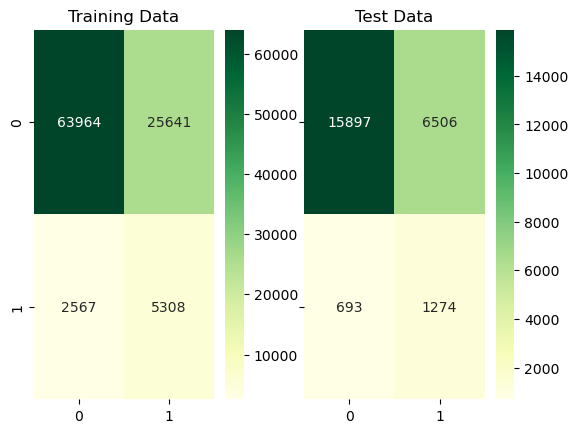

In [73]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,y_pred_xg1)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,y_pred_xg)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1]);
a[0][1].set_title('Test Data');

In [76]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
print(classification_report(y_train,y_pred_xg1))
print(classification_report(y_test,y_pred_xg))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82     89605
           1       0.17      0.67      0.27      7875

    accuracy                           0.71     97480
   macro avg       0.57      0.69      0.55     97480
weighted avg       0.90      0.71      0.78     97480

              precision    recall  f1-score   support

           0       0.96      0.71      0.82     22403
           1       0.16      0.65      0.26      1967

    accuracy                           0.70     24370
   macro avg       0.56      0.68      0.54     24370
weighted avg       0.89      0.70      0.77     24370



In [73]:
def kfold(splits, scoring):
    cv = KFold(n_splits = splits, random_state = 1, shuffle = True)
    #create model
    model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree',learning_rate=0.05,max_depth=6,
                               base_score=0.5, n_estimators=200, num_parallel_tree=6, eval_metric='auc',
                               tree_method='hist', grow_policy='lossguide', scale_pos_weight = 11,
                               gamma = 20, colsample_bytree = 0.5
                              ).fit(X_train, y_train)
    # evaluate model
    scores = cross_val_score(model, X_train, y_train, scoring = scoring, cv = cv, n_jobs = -1)
    return scores

print("ROC-AUC: %.3f (%.3f)" %(mean(kfold(4, 'roc_auc')), std(kfold(4, 'roc_auc'))))
print('ROC-AUC', kfold(4, 'roc_auc'))
print()

ROC-AUC: 0.725 (0.005)
ROC-AUC [0.72103427 0.73272516 0.72119667 0.72319238]



### Statsmodel Logistic Regression

In [74]:
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.257900
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                97480
Model:                          Logit   Df Residuals:                    97466
Method:                           MLE   Df Model:                           13
Date:                Thu, 09 Nov 2023   Pseudo R-squ.:                 0.08118
Time:                        19:32:16   Log-Likelihood:                -25140.
converged:                       True   LL-Null:                       -27361.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Rating_Origin_3                         -2.8729      0.0

In [75]:
y_pred_result1 = result.predict(X_train)
y_pred_result = result.predict(X_test)

print("ROC AUC Score for train: ", roc_auc_score(y_train, y_pred_result1) * 100)
print("ROC AUC Score for test: ", roc_auc_score(y_test, y_pred_result) * 100)

ROC AUC Score for train:  71.46979560203822
ROC AUC Score for test:  71.92171476598624


In [76]:
train['Prob_score_Stats'] = y_pred_result1
test['Prob_score_Stats'] = y_pred_result

In [77]:
stats_train_ks = ks(train, 'Default','Prob_score_Stats')
stats_test_ks = ks(test, 'Default','Prob_score_Stats')

In [78]:
stats_train_ks

,min_prob,max_prob,total,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS,ks_stats,max_ks
Decile,,,,,,,,,,,,
1,0.164169,0.469603,9748,2245,7503,28.51%,8.37%,28.51%,8.37%,20.1,20.13,
2,0.117246,0.164168,9748,1354,8394,17.19%,9.37%,45.70%,17.74%,28.0,27.96,
3,0.092037,0.117239,9748,1051,8697,13.35%,9.71%,59.05%,27.45%,31.6,31.60,*****
4,0.074459,0.092035,9748,766,8982,9.73%,10.02%,68.77%,37.47%,31.3,31.30,
5,0.061277,0.074459,9748,646,9102,8.20%,10.16%,76.98%,47.63%,29.3,29.35,
6,0.050602,0.061276,9748,526,9222,6.68%,10.29%,83.66%,57.92%,25.7,25.74,
7,0.041396,0.050601,9748,452,9296,5.74%,10.37%,89.40%,68.30%,21.1,21.10,
8,0.033022,0.041394,9748,368,9380,4.67%,10.47%,94.07%,78.76%,15.3,15.31,
9,0.024708,0.033021,9748,289,9459,3.67%,10.56%,97.74%,89.32%,8.4,8.42,


In [79]:
stats_test_ks

,min_prob,max_prob,total,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS,ks_stats,max_ks
Decile,,,,,,,,,,,,
1,0.164650,0.475538,2437,551,1886,28.01%,8.42%,28.01%,8.42%,19.6,19.59,
2,0.118410,0.164645,2437,365,2072,18.56%,9.25%,46.57%,17.67%,28.9,28.90,
3,0.092437,0.118391,2437,250,2187,12.71%,9.76%,59.28%,27.43%,31.8,31.85,
4,0.074746,0.092432,2437,197,2240,10.02%,10.00%,69.29%,37.43%,31.9,31.87,*****
5,0.061617,0.074731,2437,166,2271,8.44%,10.14%,77.73%,47.57%,30.2,30.17,
6,0.050712,0.061610,2437,135,2302,6.86%,10.28%,84.60%,57.84%,26.8,26.76,
7,0.041536,0.050704,2437,109,2328,5.54%,10.39%,90.14%,68.23%,21.9,21.91,
8,0.033044,0.041532,2437,87,2350,4.42%,10.49%,94.56%,78.72%,15.8,15.84,
9,0.024933,0.033039,2437,64,2373,3.25%,10.59%,97.81%,89.31%,8.5,8.50,


### Decision Tree

In [100]:
clf = DecisionTreeClassifier(criterion = 'gini', max_depth =6, splitter = "random",
                            min_samples_split = 4, max_features = "sqrt", 
                            class_weight={1:4})
dt = clf.fit(X_train, y_train)

y_pred_dt1 = dt.predict(X_train)
y_pred_dt = dt.predict(X_test)


In [101]:
X_train_prob = list(clf.predict_proba(X_train)[:,1])
X_test_prob = list(clf.predict_proba(X_test)[:,1])

train['Prob_score_dt'] = X_train_prob
test['Prob_score_dt'] = X_test_prob

In [102]:
print("ROC AUC Score for train:", roc_auc_score(y_train, X_train_prob) * 100)
print("ROC AUC Score for test:", roc_auc_score(y_test, X_test_prob) * 100)

ROC AUC Score for train: 67.74001989330598
ROC AUC Score for test: 67.93294102047712


In [104]:
# dt_train_ks = ks(train, 'Default','Prob_score_dt')
# dt_test_ks = ks(test, 'Default','Prob_score_dt')

In [90]:
# dt_train_ks

In [91]:
# dt_test_ks

### Random Forest

In [135]:
rf = RandomForestClassifier(n_estimators=200, max_depth = 7,
                            criterion = 'gini', min_samples_split = 5,
                            max_features = 'sqrt', max_leaf_nodes = 3,
                            class_weight = "balanced").fit(X_train, y_train)

y_pred_rf1 = rf.predict(X_train)
y_pred_rf = rf.predict(X_test)

print("ROC AUC Score for train:", roc_auc_score(y_train, y_pred_rf1) * 100)
print("ROC AUC Score for test:", roc_auc_score(y_test, y_pred_rf) * 100)
print()

ROC AUC Score for train: 65.56282803804704
ROC AUC Score for test: 65.63780778597427



In [136]:
X_train_prob = list(rf.predict_proba(X_train)[:,1])
X_test_prob = list(rf.predict_proba(X_test)[:,1])

train['Prob_score_rf'] = X_train_prob
test['Prob_score_rf'] = X_test_prob

In [137]:
print("ROC AUC Score for train:", roc_auc_score(y_train, X_train_prob) * 100)
print("ROC AUC Score for test:", roc_auc_score(y_test, X_test_prob) * 100)

ROC AUC Score for train: 70.43064228098099
ROC AUC Score for test: 70.83956205389643


In [138]:
rf_train_ks = ks(train, 'Default','Prob_score_rf')
rf_test_ks = ks(test, 'Default','Prob_score_rf')

In [139]:
rf_train_ks

,min_prob,max_prob,total,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS,ks_stats,max_ks
Decile,,,,,,,,,,,,
1,0.563701,0.638160,9748,2158,7590,27.40%,8.47%,27.40%,8.47%,18.9,18.93,
2,0.530928,0.563688,9747,1404,8343,17.83%,9.31%,45.23%,17.78%,27.5,27.45,
3,0.508660,0.530917,9746,1010,8736,12.83%,9.75%,58.06%,27.53%,30.5,30.53,
4,0.490676,0.508655,9751,795,8956,10.10%,9.99%,68.15%,37.53%,30.6,30.63,*****
5,0.473958,0.490674,9748,607,9141,7.71%,10.20%,75.86%,47.73%,28.1,28.13,
6,0.460328,0.473945,9748,473,9275,6.01%,10.35%,81.87%,58.08%,23.8,23.79,
7,0.445956,0.460321,9693,476,9217,6.04%,10.29%,87.91%,68.36%,19.5,19.55,
8,0.432061,0.445952,9800,398,9402,5.05%,10.49%,92.97%,78.86%,14.1,14.11,
9,0.410251,0.432061,9749,318,9431,4.04%,10.53%,97.00%,89.38%,7.6,7.62,


In [140]:
rf_test_ks

,min_prob,max_prob,total,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS,ks_stats,max_ks
Decile,,,,,,,,,,,,
1,0.563210,0.638160,2436,527,1909,26.79%,8.52%,26.79%,8.52%,18.3,18.27,
2,0.531945,0.563207,2438,369,2069,18.76%,9.24%,45.55%,17.76%,27.8,27.80,
3,0.509118,0.531939,2427,252,2175,12.81%,9.71%,58.36%,27.47%,30.9,30.90,
4,0.491342,0.509117,2447,208,2239,10.57%,9.99%,68.94%,37.46%,31.5,31.48,*****
5,0.474390,0.491341,2437,160,2277,8.13%,10.16%,77.07%,47.62%,29.4,29.45,
6,0.460868,0.474388,2436,113,2323,5.74%,10.37%,82.82%,57.99%,24.8,24.82,
7,0.446690,0.460839,2438,125,2313,6.35%,10.32%,89.17%,68.32%,20.9,20.85,
8,0.432825,0.446668,2434,65,2369,3.30%,10.57%,92.48%,78.89%,13.6,13.58,
9,0.410906,0.432817,2440,91,2349,4.63%,10.49%,97.10%,89.38%,7.7,7.73,


In [97]:


# Init classifier
def best_result(eta, md, npt, gam, train, test):
    xgb_cl = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree',learning_rate=eta,max_depth=md,
                               base_score=0.5, n_estimators=200, num_parallel_tree=npt, eval_metric='auc',
                               tree_method='hist', grow_policy='lossguide', scale_pos_weight = 11,
                               gamma = gam, colsample_bytree = 0.5
                              ).fit(X_train, y_train)

    y_pred_xg1 = xgb_cl.predict(X_train)
    y_pred_xg = xgb_cl.predict(X_test)
    
    X_train_prob = list(xgb_cl.predict_proba(X_train)[:,1])
    X_test_prob = list(xgb_cl.predict_proba(X_test)[:,1])
    print("learning rate: ", eta, "max depth: " , md , ", num parallel tree: " , npt , "gamma: " , gam)
    train_res = roc_auc_score(y_train, X_train_prob) * 100
    test_res = roc_auc_score(y_test, X_test_prob) * 100
    
    train['Prob_score_XGB'] = X_train_prob
    test['Prob_score_XGB'] = X_test_prob

    xg_train_ks = ks(train,'Default','Prob_score_XGB')
    xg_test_ks = ks(test,'Default','Prob_score_XGB')
    
    train_3rd_cap = xg_train_ks.reset_index()['cum_eventrate'][2]
    test_3rd_cap = xg_test_ks.reset_index()['cum_eventrate'][2]
#     print(train_3rd_cap, test_3rd_cap)
#     print("ROC AUC Score for train:", train_res)
#     print("ROC AUC Score for test:", test_res)
    return eta, md, npt, gam, train_res, test_res, train_3rd_cap, test_3rd_cap

In [98]:
my_dict = {"LearningRate": [], "Max_Depth":[], "Num_Parallel_Tree":[], "Gamma":[],
           "Train_AUC": [], "Test_AUC": [], "Train_3rd_DC": [], "Test_3rd_DC": []};
for i in [0.05, 0.04, 0.03]:
    for j in [4, 5, 6, 7]:
        for k in [3, 4, 5, 6]:
            for l in [21, 23, 25, 19]:
                try:
                    eta, md, npt, gam, train_res, test_res, train_3rd_cap, test_3rd_cap = best_result(i, j, k, l, train, test)
                    my_dict["LearningRate"].append(eta)
                    my_dict["Max_Depth"].append(md)
                    my_dict["Num_Parallel_Tree"].append(npt)
                    my_dict["Gamma"].append(gam)
                    my_dict["Train_AUC"].append(train_res)
                    my_dict["Test_AUC"].append(test_res)
                    my_dict["Train_3rd_DC"].append(train_3rd_cap)
                    my_dict["Test_3rd_DC"].append(test_3rd_cap)
#                     print(my_dict)
                except:
                    pass

                print("------------------------------------------------------------")


max depth:  4 , num parallel tree:  3 gamma:  21
------------------------------------------------------------
max depth:  4 , num parallel tree:  3 gamma:  23
------------------------------------------------------------
max depth:  4 , num parallel tree:  3 gamma:  25
------------------------------------------------------------
max depth:  4 , num parallel tree:  3 gamma:  19
------------------------------------------------------------
max depth:  4 , num parallel tree:  4 gamma:  21
------------------------------------------------------------
max depth:  4 , num parallel tree:  4 gamma:  23
------------------------------------------------------------
max depth:  4 , num parallel tree:  4 gamma:  25
------------------------------------------------------------
max depth:  4 , num parallel tree:  4 gamma:  19
------------------------------------------------------------
max depth:  4 , num parallel tree:  5 gamma:  21
------------------------------------------------------------
max depth:

max depth:  4 , num parallel tree:  5 gamma:  19
------------------------------------------------------------
max depth:  4 , num parallel tree:  6 gamma:  21
------------------------------------------------------------
max depth:  4 , num parallel tree:  6 gamma:  23
------------------------------------------------------------
max depth:  4 , num parallel tree:  6 gamma:  25
------------------------------------------------------------
max depth:  4 , num parallel tree:  6 gamma:  19
------------------------------------------------------------
max depth:  5 , num parallel tree:  3 gamma:  21
------------------------------------------------------------
max depth:  5 , num parallel tree:  3 gamma:  23
------------------------------------------------------------
max depth:  5 , num parallel tree:  3 gamma:  25
------------------------------------------------------------
max depth:  5 , num parallel tree:  3 gamma:  19
------------------------------------------------------------
max depth:

max depth:  5 , num parallel tree:  4 gamma:  25
------------------------------------------------------------
max depth:  5 , num parallel tree:  4 gamma:  19
------------------------------------------------------------
max depth:  5 , num parallel tree:  5 gamma:  21
------------------------------------------------------------
max depth:  5 , num parallel tree:  5 gamma:  23
------------------------------------------------------------
max depth:  5 , num parallel tree:  5 gamma:  25
------------------------------------------------------------
max depth:  5 , num parallel tree:  5 gamma:  19
------------------------------------------------------------
max depth:  5 , num parallel tree:  6 gamma:  21
------------------------------------------------------------
max depth:  5 , num parallel tree:  6 gamma:  23
------------------------------------------------------------
max depth:  5 , num parallel tree:  6 gamma:  25
------------------------------------------------------------
max depth:

In [99]:
my_dict

{'LearningRate': [0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,
  0.04,


In [100]:
# pd.DataFrame(my_dict).to_excel('output_v1.2.xlsx', index = False)

In [ ]:

# X_validation_prob = list(xgb_cl.predict_proba(X_validation)[:,1])


# validation['Prob_score_XGB'] = X_validation_prob


# print("ROC AUC Score for validation:", roc_auc_score(y_validation, X_validation_prob) * 100)
